# SAUS Campus Scene Classification using Transfer Learning

**Author:** Khadim Ali && Hamad Ahmed
**Dataset Creator:** Khadim Ali && Hamad Ahmed  

This notebook trains a deep learning model to classify campus images into the following 7 classes:

- Auditorium  
- Classrooms  
- Ground  
- Indoor_Places  
- Labs  
- Office  
- Outdoor_Places  

The dataset is organized in the `SAUS` directory with `Train`, `Val`, and `Test` subfolders, each containing one folder per class.

In [1]:


import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import ImageFile, Image

# To handle truncated images safely
ImageFile.LOAD_TRUNCATED_IMAGES = True

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.20.0


## Dataset paths and basic configuration

This cell defines the dataset directory structure, class names, and basic image/model hyperparameters.


In [2]:
# Root dataset directory (update path if needed)
dataset_path = "./SAUS"

train_path = os.path.join(dataset_path, "Train")
val_path   = os.path.join(dataset_path, "Val")
test_path  = os.path.join(dataset_path, "Test")

# Class names (must match folder names in each split)
classes = [
    "Auditorium",
    "Classrooms",
    "Ground",
    "Indoor_Places",
    "Labs",
    "Office",
    "Outdoor_Places",
]
num_classes = len(classes)

# Image and training parameters
IMG_HEIGHT  = 128
IMG_WIDTH   = 128
BATCH_SIZE  = 32
EPOCHS_PHASE1 = 12   # frozen base
EPOCHS_PHASE2 = 10   # fine-tuning

print("Classes:", classes)
print("Train path:", train_path)
print("Val path:", val_path)
print("Test path:", test_path)


Classes: ['Auditorium', 'Classrooms', 'Ground', 'Indoor_Places', 'Labs', 'Office', 'Outdoor_Places']
Train path: ./SAUS\Train
Val path: ./SAUS\Val
Test path: ./SAUS\Test


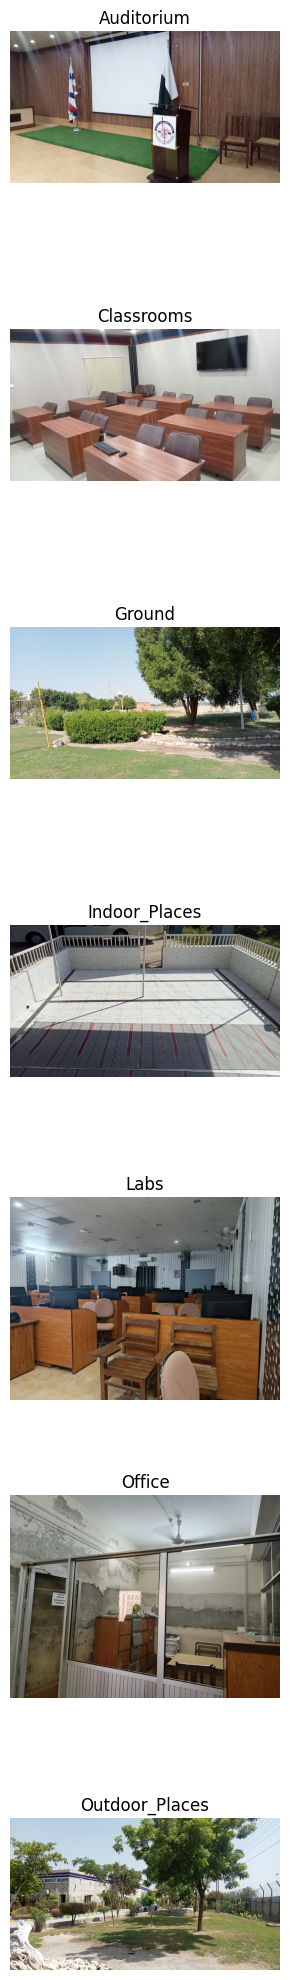

In [3]:

import random
from pathlib import Path

def show_sample_images_per_class(base_dir, class_names, samples_per_class=1):
    """
    Show a few sample images for each class from base_dir/class_name.
    """
    plt.figure(figsize=(samples_per_class * 3, len(class_names) * 3))

    img_index = 1
    for c_idx, cls in enumerate(class_names):
        class_dir = Path(base_dir) / cls
        image_files = [f for f in class_dir.glob("*") if f.suffix.lower() in [".jpg", ".jpeg", ".png"]]

        if not image_files:
            print(f"No images found for class: {cls}")
            continue

        # Randomly choose images for this class
        chosen_files = random.sample(image_files, min(samples_per_class, len(image_files)))

        for f in chosen_files:
            plt.subplot(len(class_names), samples_per_class, img_index)
            img = plt.imread(str(f))
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")
            img_index += 1

    plt.tight_layout()
    plt.show()

# Show 1 sample image per class from the training set
show_sample_images_per_class(train_path, classes, samples_per_class=1)


## Data generators and augmentation

This cell creates `ImageDataGenerator` objects for training, validation, and testing with suitable augmentation on the training set.


In [ ]:


train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest",
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

print("Creating data generators...")

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),    
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    classes=classes,
    shuffle=True,
)

val_generator = val_test_datagen.flow_from_directory(
    val _path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    classes=classes,
    shuffle=False,
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    classes=classes,
    shuffle=False,
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print("Class indices:", train_generator.class_indices)


Creating data generators...
Found 527 images belonging to 7 classes.
Found 168 images belonging to 7 classes.
Found 170 images belonging to 7 classes.
Training samples: 527
Validation samples: 168
Test samples: 170
Class indices: {'Auditorium': 0, 'Classrooms': 1, 'Ground': 2, 'Indoor_Places': 3, 'Labs': 4, 'Office': 5, 'Outdoor_Places': 6}


## Model definition (Transfer Learning with MobileNetV2)

This cell defines a function to create a transfer learning model using a chosen backbone (default: MobileNetV2) and a custom classification head for the 7 SAUS classes.


In [5]:

def create_pretrained_model(model_name="MobileNetV2"):
    """
    Create a transfer learning model with a chosen pretrained backbone.

    Supported options:
    - 'MobileNetV2'
    - 'ResNet50'
    - 'VGG16'
    - 'EfficientNetB0'
    - 'InceptionV3'
    """
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

    if model_name == "MobileNetV2":
        base_model = tf.keras.applications.MobileNetV2(
            include_top=False,
            weights="imagenet",
            input_shape=input_shape,
        )
    elif model_name == "ResNet50":
        base_model = tf.keras.applications.ResNet50(
            include_top=False,
            weights="imagenet",
            input_shape=input_shape,
        )
    elif model_name == "VGG16":
        base_model = tf.keras.applications.VGG16(
            include_top=False,
            weights="imagenet",
            input_shape=input_shape,
        )
    elif model_name == "EfficientNetB0":
        base_model = tf.keras.applications.EfficientNetB0(
            include_top=False,
            weights="imagenet",
            input_shape=input_shape,
        )
    elif model_name == "InceptionV3":
        base_model = tf.keras.applications.InceptionV3(
            include_top=False,
            weights="imagenet",
            input_shape=input_shape,
        )
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    # Freeze base model for initial training
    base_model.trainable = False

    # Custom classification head
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=base_model.input, outputs=outputs)

    return model, base_model


## Create and compile the MobileNetV2 model

This cell creates a MobileNetV2‑based model and compiles it for the first training phase with the base model frozen.


In [6]:
# Let's try MobileNetV2 first (fast and efficient)
print("Creating MobileNetV2 model...")
model, base_model = create_pretrained_model('MobileNetV2')

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Creating MobileNetV2 model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,621,255 (10.00 MB)

 Trainable params: 362,503 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

## Callbacks

This cell defines callbacks for:

- Early stopping (monitoring validation accuracy)  
- Learning rate reduction on plateau  
- Model checkpoint to save the best model


In [7]:

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        restore_best_weights=True,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        min_lr=1e-7,
    ),
    keras.callbacks.ModelCheckpoint(
        "best_mobilenetv2_saus.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode="max",
    ),
]


## Phase 1: Training with frozen base model

In this phase, only the custom classification head is trained while the pretrained backbone remains frozen.


In [8]:

print("Phase 1: Training with frozen base model...")

history1 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE1,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1,
)


Phase 1: Training with frozen base model...


c:\Users\Khadim_Ali\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 148s 8s/step - accuracy: 0.4004 - loss: 1.9060 - val_accuracy: 0.5833 - val_loss: 1.1404 - learning_rate: 0.0010
Epoch 2/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 94s 6s/step - accuracy: 0.6964 - loss: 0.9015 - val_accuracy: 0.6964 - val_loss: 0.9913 - learning_rate: 0.0010
Epoch 3/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - accuracy: 0.7704 - loss: 0.7284 - val_accuracy: 0.7202 - val_loss: 1.0303 - learning_rate: 0.0010
Epoch 4/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 99s 6s/step - accuracy: 0.7894 - loss: 0.5914 - val_accuracy: 0.7083 - val_loss: 1.0747 - learning_rate: 0.0010
Epoch 5/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 106s 6s/step - accuracy: 0.8216 - loss: 0.5466 - val_accuracy: 0.7857 - val_loss: 1.0035 - learning_rate: 0.0010
Epoch 6/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 93s 5s/step - accuracy: 0.8406 - loss: 0.4816 - val_accuracy: 0.7798 - val_loss: 0.9699 - learning_rate: 0.0010
Epoch 7/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - accuracy: 0.8899 - loss: 0.3301 - val_accuracy

## Fine‑tuning setup

This cell defines a helper function to unfreeze part of the base model for fine‑tuning with a small learning rate.


In [ ]:
def fine_tune_model(model, base_model, fine_tune_at=None, lr=1e-5):
    """
    Unfreeze part of the base model for fine-tuning.

    - fine_tune_at: index of layer in base_model from which to start training.
      If None, uses half of the layers.
    - lr: learning rate for fine-tuning.
    """
    # Unfreeze the base model
    base_model.trainable = True

    # Decide layer index to start fine-tuning
    if fine_tune_at is None:
        fine_tune_at = len(base_model.layers) // 2

    # Freeze all layers before fine_tune_at
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    # Optionally keep BatchNormalization layers frozen (stabilizes training)
    for layer in base_model.layers[fine_tune_at:]:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

    # Recompile with a lower learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Quick check: number of trainable layers in base model
    trainable_layers = np.sum([l.trainable for l in base_model.layers])
    print("Trainable layers after fine-tune:", trainable_layers)

    return model


## Phase 2: Fine‑tuning the backbone

Here the upper half of the MobileNetV2 backbone is unfrozen and trained with a small learning rate to improve accuracy.



In [ ]:
print("Phase 2: Fine-tuning...")

model = fine_tune_model(
    model,
    base_model,
    fine_tune_at=len(base_model.layers) // 2,
    lr=1e-5,
)

history2 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE2,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1,
)


Phase 2: Fine-tuning...
Trainable layers after fine-tune: 51
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step - accuracy: 0.8899 - loss: 0.3489 - val_accuracy: 0.7798 - val_loss: 0.9911 - learning_rate: 1.0000e-05
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 98s 6s/step - accuracy: 0.8843 - loss: 0.3193 - val_accuracy: 0.8095 - val_loss: 0.9567 - learning_rate: 1.0000e-05
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 100s 6s/step - accuracy: 0.8824 - loss: 0.3406 - val_accuracy: 0.7976 - val_loss: 1.0076 - learning_rate: 1.0000e-05
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 87s 5s/step - accuracy: 0.8918 - loss: 0.3312 - val_accuracy: 0.8036 - val_loss: 1.0234 - learning_rate: 1.0000e-05
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 89s 5s/step - accuracy: 0.8918 - loss: 0.3041 - val_accuracy: 0.8274 - val_loss: 0.9457 - learning_rate: 1.0000e-05
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.8861 - loss: 0.3248 - val_accuracy: 0.8214 - val_loss: 0.9259 - learning_rate: 2.0000e-06
Epoch 7/10
1

## Combine training histories

This cell merges the histories from Phase 1 and Phase 2 for plotting.


In [11]:
def combine_histories(history1, history2):
    combined_history = {}
    for key in history1.history.keys():
        combined_history[key] = history1.history[key] + history2.history[key]
    return combined_history

combined_history = combine_histories(history1, history2)


## Training and validation curves

This cell plots accuracy and loss across all epochs (both phases).


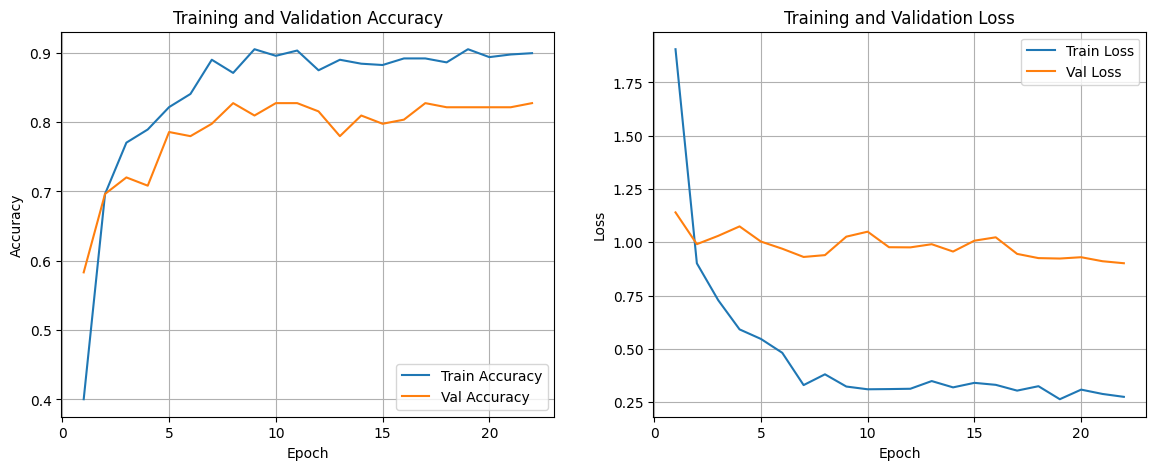

In [12]:

def plot_training(history):
    acc = history["accuracy"]
    val_acc = history["val_accuracy"]
    loss = history["loss"]
    val_loss = history["val_loss"]

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Train Accuracy")
    plt.plot(epochs_range, val_acc, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Train Loss")
    plt.plot(epochs_range, val_loss, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)

    plt.show()

plot_training(combined_history)


## Evaluation on test set

This cell evaluates the final model on the independent test set and prints overall accuracy.


In [13]:

test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9176 - loss: 0.2868
Test accuracy: 0.9176
Test loss: 0.2868


## Classification report and confusion matrix

Here we generate detailed performance metrics per class and visualize the confusion matrix.


6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
Classification Report:
                precision    recall  f1-score   support

    Auditorium       0.94      1.00      0.97        16
    Classrooms       0.85      0.81      0.83        21
        Ground       0.89      0.81      0.85        21
 Indoor_Places       0.94      0.94      0.94        47
          Labs       0.89      1.00      0.94         8
        Office       0.71      0.83      0.77         6
Outdoor_Places       0.96      0.96      0.96        51

      accuracy                           0.92       170
     macro avg       0.88      0.91      0.89       170
  weighted avg       0.92      0.92      0.92       170



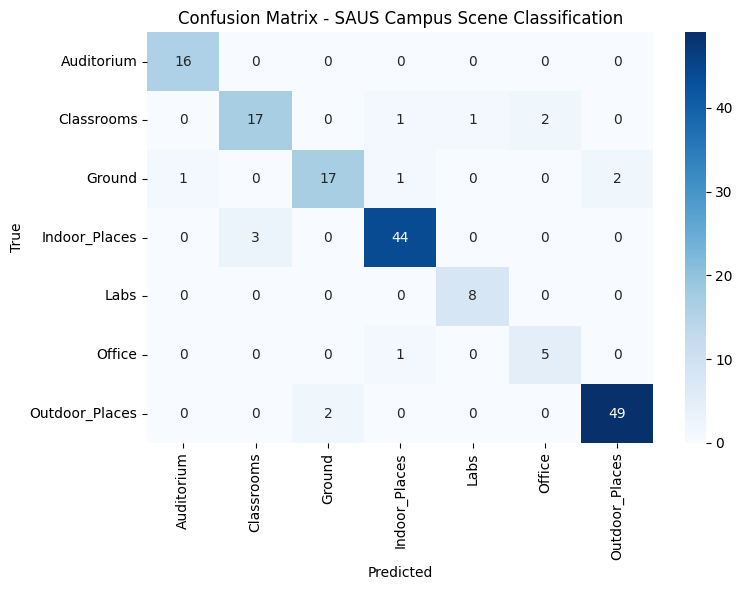

In [14]:


# Get predictions
test_generator.reset()
pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - SAUS Campus Scene Classification")
plt.tight_layout()
plt.show()


## Save final model

This cell saves the fine‑tuned model in the Keras native format for later use or deployment.


In [15]:

model.save("saus_mobilenetv2_final.keras")
print("Model saved as 'saus_mobilenetv2_final.keras'")


Model saved as 'saus_mobilenetv2_final.keras'


In [16]:

from tensorflow.keras.models import load_model

model_path = "saus_mobilenetv2_final.keras" 
loaded_model = load_model(model_path)

print("Model loaded from:", model_path)


Model loaded from: saus_mobilenetv2_final.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted class index: 1
Predicted class name : Classrooms
Confidence          : 99.62%


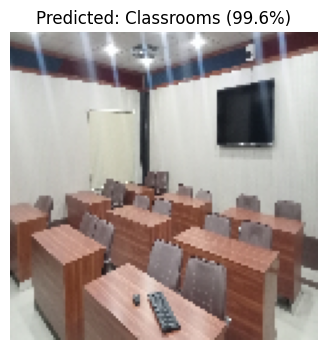

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to the image you want to test
img_path = "./SAUS/Test/Classrooms/IMG20240907104920.jpg"  

def load_and_preprocess_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0          # same rescale as generators
    img_array = np.expand_dims(img_array, axis=0)  # (1, H, W, 3)
    return img, img_array

# Load and preprocess
orig_img, input_img = load_and_preprocess_image(img_path)

# Predict
pred_probs = loaded_model.predict(input_img)
pred_class_idx = np.argmax(pred_probs[0])
pred_class_name = classes[pred_class_idx]
pred_conf = float(np.max(pred_probs[0])) * 100

print("Predicted class index:", pred_class_idx)
print("Predicted class name :", pred_class_name)
print(f"Confidence          : {pred_conf:.2f}%")

# ==============================
# Show image with prediction
# ==============================

plt.figure(figsize=(4, 4))
plt.imshow(orig_img)
plt.axis("off")
plt.title(f"Predicted: {pred_class_name} ({pred_conf:.1f}%)")
plt.show()